## All-NBA Award Predictions Project

Can we use past season data to predict the next seasons all-NBA teams?

In [549]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import warnings
import seaborn as sns
warnings.simplefilter('ignore')

__Webscraping/Data Collection__

In [550]:
#Establishing the range of seasons we are looking at
season_min = 2010
season_max = 2020

Here I am web scraping season averages and other statistics from each player from the last 11 seasons from basketball-reference.com. I pulled from 5 different datasets per year to get season averages, advanced stats, play by play data, shooting data, and per 100 possession data.

In [551]:
player_df = pd.DataFrame()
for i in range(season_min, season_max+1):
    link = "https://www.basketball-reference.com/leagues/NBA_" + str(i) + "_per_game.html"
    temp_df = pd.read_html(link)[0]
    temp_df['year'] = i
    player_df = pd.concat([player_df, temp_df])

In [552]:
player_adv = pd.DataFrame()
for i in range(season_min, season_max+1):
    link = "https://www.basketball-reference.com/leagues/NBA_" + str(i) + "_advanced.html"
    temp_df = pd.read_html(link)[0]
    temp_df['year'] = i
    player_adv = pd.concat([player_adv, temp_df])

In [553]:
player_pbp = pd.DataFrame()
for i in range(season_min, season_max+1):
    link = "https://www.basketball-reference.com/leagues/NBA_" + str(i) + "_play-by-play.html"
    temp_df = pd.read_html(link)[0]
    temp_df['year'] = i
    player_pbp = pd.concat([player_pbp, temp_df])

In [554]:
player_shoot = pd.DataFrame()
for i in range(season_min, season_max+1):
    link = "https://www.basketball-reference.com/leagues/NBA_" + str(i) + "_shooting.html"
    temp_df = pd.read_html(link)[0]
    temp_df['year'] = i
    player_shoot = pd.concat([player_shoot, temp_df])

In [555]:
player_100 = pd.DataFrame()
for i in range(season_min, season_max+1):
    link = "https://www.basketball-reference.com/leagues/NBA_" + str(i) + "_per_poss.html"
    temp_df = pd.read_html(link)[0]
    temp_df['year'] = i
    player_100 = pd.concat([player_100, temp_df])

In [556]:
#Checking to make sure the same amount of players were pulled in for each statistic
#Per 100 Possession
len(player_100)
#Per game Stats
len(player_df)
#Advanced Stats
len(player_adv)
#shooting
len(player_shoot)
#Play by Play
len(player_pbp)

7048

The next blocks of code are taking only the variables I was interested in using in my analysis from each table. This also prevents variables from being repeats.

In [557]:
player_shoot.columns = player_shoot.columns.droplevel(0)
player_pbp.columns = player_pbp.columns.droplevel(0)

In [558]:
player_df = player_df[['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'year']]
player_100 = player_100 [['ORtg', 'DRtg']]
player_adv = player_adv[['PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
        'OWS', 'DWS', 'WS', 'WS/48','OBPM',
       'DBPM', 'BPM', 'VORP']]
player_pbp = player_pbp[['PG%', 'SG%', 'SF%',
       'PF%', 'C%', 'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'Shoot',
       'Off.', 'Shoot', 'Off.', 'PGA', 'And1', 'Blkd']]
player_shoot = player_shoot[['Dist.', '0-3', '3-10', '10-16', '16-3P']]
player_all = pd.concat([player_df, player_100, player_adv, player_pbp, player_shoot], axis = 1)

The following code gets the all-NBA teams from the last 10 years from Wikipedia and then formats it for better use:

In [559]:
allNBA = pd.read_html("https://en.wikipedia.org/wiki/All-NBA_Team")

In [560]:
allNBA_recent = allNBA[7][110:]
allNBA_recent.head()

Season          First team                         \
      Season             Players                  Teams   
110  2010–11   Kevin Durant^ (2)  Oklahoma City Thunder   
111  2010–11   LeBron James^ (7)             Miami Heat   
112  2010–11  Dwight Howard^ (5)          Orlando Magic   
113  2010–11   Kobe Bryant* (13)     Los Angeles Lakers   
114  2010–11       Derrick Rose^          Chicago Bulls   

               Second team                                 Third team  \
                   Players                  Teams             Players   
110         Pau Gasol^ (3)     Los Angeles Lakers  LaMarcus Aldridge^   
111     Dirk Nowitzki (11)       Dallas Mavericks       Zach Randolph   
112  Amar'e Stoudemire (5)        New York Knicks         Al Horford^   
113        Dwyane Wade (6)             Miami Heat   Manu Ginóbili (2)   
114     Russell Westbrook^  Oklahoma City Thunder     Chris Paul^ (3)   

                             
                      Teams  
110  Portland Trail Blazers  
111       Memphis Grizzlies  
112           Atlanta Hawks  
113       San Antonio Spurs  
114     New Orleans Hornets

In [561]:
allNBA_recent['First'] = allNBA_recent['First team']['Players']
allNBA_recent['Second']  = allNBA_recent['Second team']['Players']
allNBA_recent['Third']  = allNBA_recent['Third team']['Players']
allNBA_recent['year']  = allNBA_recent['Season']['Season']

__Data Cleaning and Feature Creation__

In [562]:
allNBA_df = allNBA_recent[['year', 'First', 'Second', 'Third']]

In [563]:
allNBA_df = allNBA_recent[['year', 'First', 'Second', 'Third']]
allNBA_df['First'] = allNBA_df['First'].apply(lambda x: re.findall('\w+', str(x))[0] + " " + re.findall('\w+', str(x))[1])
allNBA_df['Second'] = allNBA_df['Second'].apply(lambda x: re.findall('\w+', str(x))[0] + " " + re.findall('\w+', str(x))[1])
allNBA_df['Third'] = allNBA_df['Third'].apply(lambda x: re.findall('\w+', str(x))[0] + " " + re.findall('\w+', str(x))[1])
allNBA_df['year'] = allNBA_df['year'].apply(lambda x: "20" + re.findall('\w+', str(x))[1])
allNBA_df.at[112, 'Second']= "Amar'e Stoudemire"
#allNBA_df

The following blocks of code is cleaning the data set in a few ways. I double check to make sure there are no repeats and then I alter some column names to make them more interpretable. I also remove the header rows in the middle of the dataset.

In [564]:
#Checking to make sure columns are unique
cols = pd.Series(player_all.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
player_all.columns = cols
player_all.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'year', 'ORtg',
       'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', 'PG%', 'SG%', 'SF%', 'PF%', 'C%', 'OnCourt',
       'On-Off', 'BadPass', 'LostBall', 'Shoot', 'Shoot.1', 'Off.', 'Off..1',
       'Shoot.2', 'Shoot.3', 'Off..2', 'Off..3', 'PGA', 'And1', 'Blkd',
       'Dist.', '0-3', '0-3.1', '3-10', '3-10.1', '10-16', '10-16.1', '16-3P',
       '16-3P.1'],
      dtype='object')

In [565]:
#Making the column names correct
player_clean = player_all[['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg',
       'DRtg', 'year', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'PG%', 'SG%', 'SF%', 'PF%', 'C%',
       'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'Shoot', 'Shoot.1', 'Off.',
       'Off..1', 'PGA', 'And1',
       'Blkd', 'Dist.', '0-3', '0-3.1', '3-10', '3-10.1', '10-16', '10-16.1',
       '16-3P', '16-3P.1']]
player_clean.columns = ['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg',
       'DRtg', 'year', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'PG%', 'SG%', 'SF%', 'PF%', 'C%',
       'OnCourt +/-', 'On-Off +/-', 'BadPass', 'LostBall', 'Shoot Foul Commit', 'Shoot Foul Drawn', 'Off Foul Commit',
       'Off Foul Drawn', 'PGA', 'And1',
       'Blkd', 'Avg Dist on Shot', '0-3 FGA', '0-3 FG%', '3-10 FGA', '3-10 FG%', '10-16 FGA', '10-16 FG%',
       '16-3P FGA', '16-3P FG%']
player_clean = player_clean[player_clean['Player'] != "Player"]
player_clean = player_clean.drop_duplicates(subset = ['Player','year'], keep = 'first')
#player_clean.tail(25)['year']

Next I combined the all-NBA data to our overall player data. I put a 1 if they made the all-NBA team the following year and a 0 if they didn't. I also made a variable "All NBA Prev" which just shows if they were on an all-NBA team from the year the stats were pulled for them. This was to see if I could use that information in my model to predict whether or not they would make it the next year. I then removed missing values by replacing them with a 0 (as in all cases I could see the reason that they were missing is because it was 0. I then converted the data types to what they should be.

In [566]:
allNBA_search = allNBA_df
player_clean['Player Key'] = player_clean['Player'].astype(str) + player_clean['year'].astype(str)
#All NBA if they made it the next year
allNBA_search['First Key'] = allNBA_search['First'] + (allNBA_search['year'].astype(int)-1).astype(str)
allNBA_search['Second Key'] = allNBA_search['Second'] + (allNBA_search['year'].astype(int)-1).astype(str)
allNBA_search['Third Key'] = allNBA_search['Third'] + (allNBA_search['year'].astype(int)-1).astype(str)
#All NBA year of the stats pulled for the player
allNBA_search['First Key2'] = allNBA_search['First'] + (allNBA_search['year'].astype(int)).astype(str)
allNBA_search['Second Key2'] = allNBA_search['Second'] + (allNBA_search['year'].astype(int)).astype(str)
allNBA_search['Third Key2'] = allNBA_search['Third'] + (allNBA_search['year'].astype(int)).astype(str)
#allNBA_search

In [567]:
#Adding All NBA data and removing NA's along with changing some variable types
player_clean['All NBA 1st'] = player_clean['Player Key'].isin(allNBA_search['First Key']).astype(int)
player_clean['All NBA 2nd'] = player_clean['Player Key'].isin(allNBA_search['Second Key']).astype(int)
player_clean['All NBA 3rd'] = player_clean['Player Key'].isin(allNBA_search['Third Key']).astype(int)
player_clean['All NBA'] = player_clean[['All NBA 1st', "All NBA 2nd", "All NBA 3rd"]].sum(axis=1)
player_clean['All NBA 1st2'] = player_clean['Player Key'].isin(allNBA_search['First Key2']).astype(int)
player_clean['All NBA 2nd2'] = player_clean['Player Key'].isin(allNBA_search['Second Key2']).astype(int)
player_clean['All NBA 3rd2'] = player_clean['Player Key'].isin(allNBA_search['Third Key2']).astype(int)
player_clean['All NBA Prev'] = player_clean[['All NBA 1st2', "All NBA 2nd2", "All NBA 3rd2"]].sum(axis=1)
player_clean[['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg',
       'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'PG%', 'SG%', 'SF%', 'PF%', 'C%',
       'OnCourt +/-', 'On-Off +/-', 'BadPass', 'LostBall', 'Shoot Foul Commit', 'Shoot Foul Drawn', 'Off Foul Commit',
       'Off Foul Drawn', 'PGA', 'And1',
       'Blkd', 'Avg Dist on Shot', '0-3 FGA', '0-3 FG%', '3-10 FGA', '3-10 FG%', '10-16 FGA', '10-16 FG%',
       '16-3P FGA', '16-3P FG%']] =  player_clean[['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg',
       'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'PG%', 'SG%', 'SF%', 'PF%', 'C%',
       'OnCourt +/-', 'On-Off +/-', 'BadPass', 'LostBall', 'Shoot Foul Commit', 'Shoot Foul Drawn', 'Off Foul Commit',
       'Off Foul Drawn', 'PGA', 'And1',
       'Blkd', 'Avg Dist on Shot', '0-3 FGA', '0-3 FG%', '3-10 FGA', '3-10 FG%', '10-16 FGA', '10-16 FG%',
       '16-3P FGA', '16-3P FG%']].fillna(0)
player_clean[['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg',
       'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP',
       'OnCourt +/-', 'On-Off +/-', 'BadPass', 'LostBall', 'Shoot Foul Commit', 'Shoot Foul Drawn', 'Off Foul Commit',
       'Off Foul Drawn', 'PGA', 'And1',
       'Blkd', 'Avg Dist on Shot', '0-3 FGA', '0-3 FG%', '3-10 FGA', '3-10 FG%', '10-16 FGA', '10-16 FG%',
       '16-3P FGA', '16-3P FG%']] = player_clean[['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg',
       'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP',
       'OnCourt +/-', 'On-Off +/-', 'BadPass', 'LostBall', 'Shoot Foul Commit', 'Shoot Foul Drawn', 'Off Foul Commit',
       'Off Foul Drawn', 'PGA', 'And1',
       'Blkd', 'Avg Dist on Shot', '0-3 FGA', '0-3 FG%', '3-10 FGA', '3-10 FG%', '10-16 FGA', '10-16 FG%',
       '16-3P FGA', '16-3P FG%']].astype(float)
player_clean[['PG%','SG%','SF%','PF%','C%']] = player_clean[['PG%','SG%','SF%','PF%','C%']].astype(str)
player_clean['PG%'] = player_clean['PG%'].str.replace(r'%', r'.0').astype('float') / 100.0 
player_clean['SG%'] = player_clean['SG%'].str.replace(r'%', r'.0').astype('float') / 100.0 
player_clean['SF%'] = player_clean['SF%'].str.replace(r'%', r'.0').astype('float') / 100.0 
player_clean['PF%'] = player_clean['PF%'].str.replace(r'%', r'.0').astype('float') / 100.0 
player_clean['C%'] = player_clean['C%'].str.replace(r'%', r'.0').astype('float') / 100.0 
#player_clean.dtypes

Next I narrowed down the columns to get rid of a few extras that had come up. I then removed the player data from 2020 as there is no data on whether or not they have made the all-NBA team in 2021 which is what I want to predict. I also only took players who had played 55 games or more as that is a requirement for all-NBA awards and will filter out the players who played well in only 1 or 2 games in the season.

In [568]:
#Getting only the columns we will need and only taking players with enough games played
players_2020 = player_clean[player_clean['year']==2020]
player_clean2 = player_clean[player_clean['year']!=2020]
players_ready = player_clean2[['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg',
       'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'PG%', 'SG%', 'SF%', 'PF%', 'C%',
       'OnCourt +/-', 'On-Off +/-', 'BadPass', 'LostBall', 'Shoot Foul Commit', 'Shoot Foul Drawn', 'Off Foul Commit',
       'Off Foul Drawn', 'PGA', 'And1',
       'Blkd', 'Avg Dist on Shot', '0-3 FGA', '0-3 FG%', '3-10 FGA', '3-10 FG%', '10-16 FGA', '10-16 FG%',
       '16-3P FGA', '16-3P FG%', 'All NBA Prev', 'All NBA']]
players_ready = players_ready[players_ready['G']>54]
#players_ready

__EDA__

Here `I look at some different summary statistics and Graphs to see what insights I could find before developing my model.

In [569]:
#Looking at some summary statistics and graphs for EDA
AllNBAaverages = players_ready[players_ready['All NBA']==1].mean()
NonAverages = players_ready[players_ready['All NBA']==0].mean()
Differences = (AllNBAaverages - NonAverages)/abs(NonAverages)*100
compare = pd.DataFrame((AllNBAaverages,NonAverages,Differences))
compare.iloc[2].sort_values(ascending=False).head(40)
compare['Index'] = ['All-NBA','Other','Percent Increase']
compare = compare.set_index('Index')[['PTS', 'FG%', '3P','3P%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
        'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM',
       'OnCourt +/-',]]
compare.head()

,PTS,FG%,3P,3P%,FTA,FT%,TRB,AST,STL,BLK,TOV,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,OnCourt +/-
Index,,,,,,,,,,,,,,,,,,,,
All-NBA,21.509774,0.491744,1.278195,0.303293,6.215789,0.783526,7.551880,5.088722,1.330827,0.858647,2.755639,27.024060,6.765414,3.528571,10.290977,0.192038,4.169925,0.913534,5.078195,5.812030
Other,10.322444,0.458387,0.849824,0.285971,2.268939,0.752172,4.328359,2.202272,0.772111,0.491774,1.356953,18.990208,1.970779,1.782256,3.752722,0.097549,-0.362476,-0.006032,-0.369526,-0.131806
Percent Increase,108.378695,7.277027,50.407130,6.057334,173.951430,4.168510,74.474438,131.066925,72.362089,74.601737,103.075560,42.305238,243.286178,97.983404,174.226992,96.862380,1250.401777,15244.492725,1474.245610,4509.543174


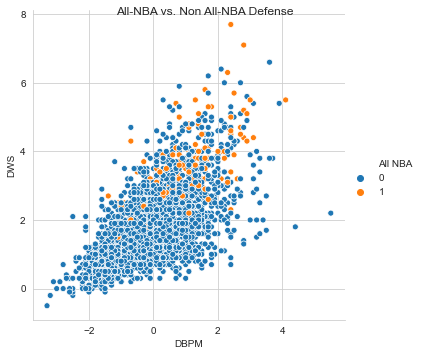

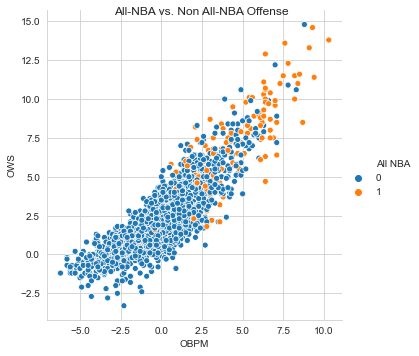

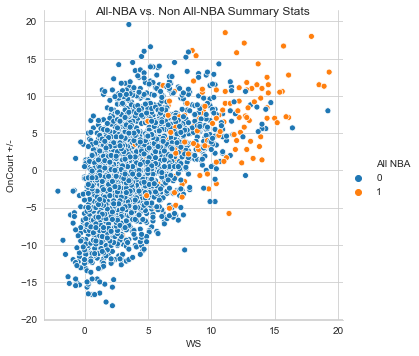

In [570]:
#Examining a few graphs
sns.set_style('whitegrid')
a = sns.relplot(x='DBPM',y='DWS',hue='All NBA',data=players_ready)
a.fig.suptitle("All-NBA vs. Non All-NBA Defense")
b = sns.relplot(x='OBPM',y='OWS',hue='All NBA',data=players_ready)
b.fig.suptitle("All-NBA vs. Non All-NBA Offense")
c = sns.relplot(x='WS',y='OnCourt +/-',hue='All NBA',data=players_ready)
c.fig.suptitle("All-NBA vs. Non All-NBA Summary Stats")
a.savefig("All-NBA_Plot1.png")
b.savefig("All-NBA_Plot2.png")
c.savefig("All-NBA_Plot3.png")

In [571]:
players_ready.to_csv("NBAplayerData.csv", index = False)
players_2020.to_csv("NBAplayerData2020.csv", index = False)

__Model Creation__

In [572]:
#Importing all potential packages needed for modeling
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PolynomialFeatures
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

Here I generate a few different types of models by first using a pipeline to both scale the data and organize categorical columns. I tried a simple logistic regression model, a decision tree, a random forest model, and a a gradient boosting model.

In [598]:
#Getting our y and our x data
y_train = players_ready['All NBA']
X_train = players_ready[['Pos', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'ORtg',
       'DRtg', 'TS%', 'PER', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'PG%', 'SG%', 'SF%', 'PF%', 'C%',
       'OnCourt +/-', 'On-Off +/-', 'BadPass', 'LostBall', 'Shoot Foul Commit', 'Shoot Foul Drawn', 'Off Foul Commit',
       'Off Foul Drawn', 'PGA', 'And1',
       'Blkd', 'Avg Dist on Shot', '0-3 FGA', '0-3 FG%', '3-10 FGA', '3-10 FG%', '10-16 FGA', '10-16 FG%',
       '16-3P FGA', '16-3P FG%']]

In [599]:
#Creating a pipeline for the data
class ColumnExtractor(TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols

#  Numerical features
numeric_columns = X_train.select_dtypes(exclude='object').columns

#  Categorical features
categorical_columns = X_train.select_dtypes('object').columns
    
#  Define the Pipeline
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric', Pipeline([
            ('extract', ColumnExtractor(numeric_columns)),
            ('impute', SimpleImputer())
        ])),
        ('categorical', Pipeline([
            ('extract', ColumnExtractor(categorical_columns)),
            ('impute', SimpleImputer(strategy='constant', fill_value='None')),
            ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])),
    ])),
    #('poly', PolynomialFeatures(degree=2, interaction_only=True)), 
    ('scale', StandardScaler())  #  scale all features
])

In [600]:
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X_train, y_train, test_size=.20, random_state=100)

In [576]:
full_pipeline_simple = Pipeline([('pipeline', pipeline),
                             ('lm', LogisticRegressionCV(max_iter = 4000))])

full_pipeline_simple.fit(Xtrain1, ytrain1)

yhat = full_pipeline_simple.predict(Xtest1)

In [577]:
#Decision Tree
full_pipeline_dt= Pipeline([('pipeline', pipeline),
                             ('lm',  DecisionTreeClassifier())])
full_pipeline_dt.fit(Xtrain1, ytrain1)

yhatdt = full_pipeline_dt.predict(Xtest1)

In [601]:
#Random Forest
full_pipeline_rf= Pipeline([('pipeline', pipeline),
                             ('lm',  RandomForestClassifier(max_depth=12))])
full_pipeline_rf.fit(Xtrain1, ytrain1)

yhatrf = full_pipeline_rf.predict(Xtest1)

In [579]:
#Gradient Boosting
full_pipeline_gb= Pipeline([('pipeline', pipeline),
                             ('lm',  GradientBoostingClassifier())])
full_pipeline_gb.fit(Xtrain1, ytrain1)
yhatgb = (full_pipeline_gb.predict(Xtest1))

In [580]:
probs = full_pipeline_simple.predict_proba(Xtest1)[:,1]
probsrf = full_pipeline_rf.predict_proba(Xtest1)[:,1]

In [581]:
#Looking at some of the probabilities and prediction and the corresponding statistics
Xtest1['pred']=yhat
Xtest1['preddt']=yhatdt
Xtest1['predrf']=yhatrf
Xtest1['prob']=probs
Xtest1['probsrf']=probsrf
GoodGuys = Xtest1[Xtest1['pred']==1]
PlayerIndices = GoodGuys.index.values.tolist() 
Xtest1[Xtest1['probsrf']>.45][['Pos', 'Age', 'G','FG%', '3P',
       '3P%', 'FT', 'FTA', 'FT%', 'OWS',
       'TRB', 'AST', 'STL', 'BLK', 'TOV','PTS', 'prob', 'probsrf','preddt', 'predrf', 'pred']]

,Pos,Age,G,FG%,3P,3P%,FT,FTA,FT%,OWS,...,AST,STL,BLK,TOV,PTS,prob,probsrf,preddt,predrf,pred
19,SF,22.0,80.0,0.521,0.6,0.272,5.9,7.7,0.770,7.9,...,5.4,1.6,1.9,2.9,22.9,0.735661,0.820000,1,1,1
425,PG,27.0,70.0,0.481,1.1,0.328,4.1,4.6,0.885,10.6,...,9.7,2.4,0.1,2.3,16.9,0.576320,0.760000,0,1,1
148,PF,28.0,62.0,0.537,1.9,0.375,5.4,6.2,0.875,8.0,...,4.8,1.1,1.6,2.2,25.1,0.698482,0.710000,1,1,1
126,C,23.0,75.0,0.505,0.5,0.299,6.9,8.6,0.802,5.9,...,2.1,1.3,2.2,2.4,28.0,0.749920,0.500000,0,0,1
64,C,25.0,70.0,0.518,0.1,0.364,6.7,8.4,0.797,7.9,...,2.4,0.6,1.0,2.4,24.0,0.405801,0.471667,0,0,0
700,PG,30.0,73.0,0.428,1.6,0.290,4.1,6.2,0.656,1.8,...,10.7,1.9,0.5,4.5,22.9,0.703854,0.516087,0,1,1
19,PF,24.0,72.0,0.578,0.7,0.256,6.9,9.5,0.729,8.9,...,5.9,1.3,1.5,3.7,27.7,0.967268,0.850000,1,1,1
340,PF,23.0,55.0,0.448,1.9,0.372,6.9,8.4,0.824,7.6,...,2.0,0.9,0.5,2.3,26.0,0.449580,0.460000,1,0,0
462,PG,28.0,62.0,0.467,1.3,0.368,4.8,5.6,0.855,9.0,...,10.7,2.5,0.1,2.3,19.1,0.636580,0.580000,0,1,1
258,SG,25.0,81.0,0.440,2.6,0.375,8.8,10.2,0.868,12.2,...,7.0,1.9,0.7,4.0,27.4,0.880572,0.940000,0,1,1


__Model Evaluation__

Looking at a variety of different metrics to see which model works best. Precision and Recall are the most important ones for this analysis.

In [582]:
print(accuracy_score(ytest1, yhat))
print(f1_score(ytest1, yhat))
print(precision_score(ytest1, yhat))
print(recall_score(ytest1, yhat))
print(roc_auc_score(ytest1, yhat))
confusion_matrix(ytest1, yhat)

0.9684014869888475
0.5405405405405405
0.7142857142857143
0.43478260869565216
0.7135078092021949


array([[511,   4],
       [ 13,  10]], dtype=int64)

In [583]:
THRESHOLD = 0.45
preds = np.where(full_pipeline_simple.predict_proba(Xtest1)[:,1] > THRESHOLD, 1, 0)

In [584]:
print(accuracy_score(ytest1, preds))
print(f1_score(ytest1, preds))
print(precision_score(ytest1, preds))
print(recall_score(ytest1, preds))
print(roc_auc_score(ytest1, preds))
confusion_matrix(ytest1, preds)

0.9646840148698885
0.5128205128205128
0.625
0.43478260869565216
0.7115660616293795


array([[509,   6],
       [ 13,  10]], dtype=int64)

In [585]:
print(accuracy_score(ytest1, yhatdt))
print(f1_score(ytest1, yhatdt))
print(precision_score(ytest1, yhatdt))
print(recall_score(ytest1, yhatdt))
print(roc_auc_score(ytest1, yhatdt))
confusion_matrix(ytest1, yhatdt)

0.9460966542750929
0.3555555555555555
0.36363636363636365
0.34782608695652173
0.6603208104685521


array([[501,  14],
       [ 15,   8]], dtype=int64)

In [602]:
print(accuracy_score(ytest1, yhatrf))
print(f1_score(ytest1, yhatrf))
print(precision_score(ytest1, yhatrf))
print(recall_score(ytest1, yhatrf))
print(roc_auc_score(ytest1, yhatrf))
confusion_matrix(ytest1, yhatrf)

0.966542750929368
0.55
0.6470588235294118
0.4782608695652174
0.7333051920641621


array([[509,   6],
       [ 12,  11]], dtype=int64)

In [603]:
THRESHOLD = 0.45
rfpreds = np.where(full_pipeline_rf.predict_proba(Xtest1)[:,1] > THRESHOLD, 1, 0)

In [604]:
print(accuracy_score(ytest1, rfpreds))
print(f1_score(ytest1, rfpreds))
print(precision_score(ytest1, rfpreds))
print(recall_score(ytest1, rfpreds))
print(roc_auc_score(ytest1, rfpreds))
confusion_matrix(ytest1, rfpreds)

0.9684014869888475
0.5853658536585366
0.6666666666666666
0.5217391304347826
0.7550443224989448


array([[509,   6],
       [ 11,  12]], dtype=int64)

In [605]:
print(accuracy_score(ytest1, yhatgb))
print(f1_score(ytest1, yhatgb))
print(precision_score(ytest1, yhatgb))
print(recall_score(ytest1, yhatgb))
print(roc_auc_score(ytest1, yhatgb))
confusion_matrix(ytest1, yhatgb)

0.9572490706319703
0.46511627906976744
0.5
0.43478260869565216
0.7076825664837484


array([[505,  10],
       [ 13,  10]], dtype=int64)

In [590]:
THRESHOLD = 0.45
gbpreds = np.where(full_pipeline_gb.predict_proba(Xtest1)[:,1] > THRESHOLD, 1, 0)

In [591]:
print(accuracy_score(ytest1, gbpreds))
print(f1_score(ytest1, gbpreds))
print(precision_score(ytest1, gbpreds))
print(recall_score(ytest1, gbpreds))
print(roc_auc_score(ytest1, gbpreds))
confusion_matrix(ytest1, gbpreds)

0.9553903345724907
0.4782608695652174
0.4782608695652174
0.4782608695652174
0.7274799493457155


array([[503,  12],
       [ 12,  11]], dtype=int64)

In [611]:
#Creating Model from all data 2010-2019
full_pipeline_simple = Pipeline([('pipeline', pipeline),
                             ('lm', LogisticRegressionCV(max_iter = 4000))])
full_pipeline_simple.fit(X_train, y_train)

full_pipeline_rf= Pipeline([('pipeline', pipeline),
                             ('lm',  RandomForestClassifier(max_depth=12))])
full_pipeline_rf.fit(X_train, y_train)


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('features',
                                  FeatureUnion(transformer_list=[('numeric',
                                                                  Pipeline(steps=[('extract',
                                                                                   <__main__.ColumnExtractor object at 0x0000024E89BE3970>),
                                                                                  ('impute',
                                                                                   SimpleImputer())])),
                                                                 ('categorical',
                                                                  Pipeline(steps=[('extract',
                                                                                   <__main__.ColumnExtractor object at 0x0000024E8D750700>),
                                                                                  ('impute',
       

__Conclusion (see README.md file for more info on conclusions)__

Here is the code to generate the predictions for the next NBA season as well as examining them. I looked at the normal logistic regression, random forest, and gradient boosting as all of them performed similar. See the write up for a conclusion to the project.

In [593]:
#Predicting 2021 awards from 2020 data
players_2020X= players_2020[['Pos', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg',
       'DRtg', 'TS%', 'PER','3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'PG%', 'SG%', 'SF%', 'PF%', 'C%',
       'OnCourt +/-', 'On-Off +/-', 'BadPass', 'LostBall', 'Shoot Foul Commit', 'Shoot Foul Drawn', 'Off Foul Commit',
       'Off Foul Drawn', 'PGA', 'And1',
       'Blkd', 'Avg Dist on Shot', '0-3 FGA', '0-3 FG%', '3-10 FGA', '3-10 FG%', '10-16 FGA', '10-16 FG%',
       '16-3P FGA', '16-3P FG%']]

In [612]:
preds = np.where(full_pipeline_simple.predict_proba(players_2020X)[:,1] > THRESHOLD, 1, 0)
probs2020 = full_pipeline_simple.predict_proba(players_2020X)[:,1]
rfpreds = np.where(full_pipeline_rf.predict_proba(players_2020X)[:,1] > THRESHOLD, 1, 0)
rfprobs2020 = full_pipeline_rf.predict_proba(players_2020X)[:,1]

In [613]:
players_2020X['preds'] = preds
players_2020X['rfpreds'] = rfpreds
players_2020X['probs'] = probs2020
players_2020X['rfprobs'] = rfprobs2020
players_2020X['averageprobs'] = (players_2020X['rfprobs'] + players_2020X['probs'])/2
players_2020X['Player'] = players_2020['Player']
players_2020X['Team'] = players_2020['Tm']
players_2020Filter = players_2020X[players_2020X['G']>30]
playerpredDF = players_2020Filter[players_2020Filter['probs']>.2][['Player', 'Team','Pos', 'Age', 'G','FG%', '3P',
       '3PA', '3P%',
       'TRB', 'AST', 'STL', 'BLK', 'PTS', 'probs', 'preds', 'rfpreds','rfprobs','averageprobs']].sort_values(by='rfprobs', ascending = False)
playerpredDF 

,Player,Team,Pos,Age,G,FG%,3P,3PA,3P%,TRB,AST,STL,BLK,PTS,probs,preds,rfpreds,rfprobs,averageprobs
266,James Harden,HOU,SG,30.0,68.0,0.444,4.4,12.4,0.355,6.6,7.5,1.8,0.9,34.3,0.866637,1,1,0.880000,0.873319
12,Giannis Antetokounmpo,MIL,PF,25.0,63.0,0.553,1.4,4.7,0.304,13.6,5.6,1.0,1.0,29.5,0.992451,1,1,0.750000,0.871226
183,Luka Dončić,DAL,PG,20.0,61.0,0.463,2.8,8.9,0.316,9.4,8.8,1.0,0.2,28.8,0.963143,1,1,0.745000,0.854072
331,LeBron James,LAL,PG,35.0,67.0,0.493,2.2,6.3,0.348,7.8,10.2,1.2,0.5,25.3,0.828170,1,1,0.740000,0.784085
387,Kawhi Leonard,LAC,SF,28.0,57.0,0.470,2.2,5.7,0.378,7.1,4.9,1.8,0.6,27.1,0.755883,1,1,0.695000,0.725442
168,Anthony Davis,LAL,PF,26.0,62.0,0.503,1.2,3.5,0.330,9.3,3.2,1.5,2.3,26.1,0.780293,1,1,0.640130,0.710211
390,Damian Lillard,POR,PG,29.0,66.0,0.463,4.1,10.2,0.401,4.3,8.0,1.1,0.3,30.0,0.582303,1,1,0.595000,0.588652
571,Ben Simmons,PHI,PG,23.0,57.0,0.580,0.0,0.1,0.286,7.8,8.0,2.1,0.6,16.4,0.608038,1,1,0.535666,0.571852
605,Karl-Anthony Towns,MIN,C,24.0,35.0,0.508,3.3,7.9,0.412,10.8,4.4,0.9,1.2,26.5,0.408398,0,1,0.475000,0.441699
103,Jimmy Butler,MIA,SF,30.0,58.0,0.455,0.5,2.1,0.244,6.7,6.0,1.8,0.6,19.9,0.497559,1,1,0.470820,0.484189


In [ ]:
#Looking at some Jazz players as well as Celtics players (my favorite teams)
print(players_2020Filter[players_2020Filter['Team']=='UTA'][['Player','Pos', 'Age', 'G','FG%', '3P',
       '3PA', '3P%',
       'TRB', 'AST', 'STL', 'BLK', 'PTS', 'probs', 'preds','rfpreds','rfprobs',]].sort_values(by='rfprobs', ascending = False))
players_2020Filter[players_2020Filter['Team']=='BOS'][['Player','Pos', 'Age', 'G','FG%', '3P',
       '3PA', '3P%',
       'TRB', 'AST', 'STL', 'BLK', 'PTS', 'probs', 'preds','rfpreds','rfprobs',]].sort_values(by='rfprobs', ascending = False)